In [1]:
# !pip uninstall snowflake -y

In [2]:
# general
import boto3
import datetime as dt
import json
import numpy as np
import pandas as pd
import snowflake.connector

In [3]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [4]:
pd.options.display.float_format = '{:,.2f}'.format

# 0. Read Training Data

In [11]:
import xgboost  
from xgboost import XGBRegressor
from sklearn.model_selection import GroupKFold

In [12]:
training_data = pd.read_csv('training_data.csv')

In [7]:
training_data[training_data['title'] == 'Wonder Woman 1984']

,Unnamed: 0,title_id,title,home_territory_observed_medal,pillar_genres,imdb_id,theatrical_release_date,offering_start_date,days_from_theatrical2,pct_actives,days_from_max_launch,cumulative_viewing_subs,cumulative_first_views,area_gross,budget,genre_Action/Adventure,genre_Comedy,genre_Drama,genre_Horror,genre_Kids/Family,genre_Romance,genre_Sci-Fi,genre_Suspense/Thriller,medal_Bronze,medal_Gold,medal_Platinum,medal_Silver,medal_number,log_cumulative_first_views,platform
84,84,GX9KHPw1OIMPCJgEAAAAD,Wonder Woman 1984,Platinum,Action/Adventure,tt7126948,2020-12-25,2020-12-25,0,0.64,-219,13629947,2784313,"16,701,957.00","200,000,000.00",1,0,0,0,0,0,0,0,0,0,1,0,0,21.41,1.00


# 1. Viewing Subs

In [14]:
META_COLS = ['title']#['title_id', 'title', 'home_territory_observed_medal', 'pillar_genres', 'imdb_id']

In [15]:
FEATURE_COLS = ['days_from_theatrical2', 'area_gross', 'budget', 'genre_Action/Adventure ', 'medal_number'
                , 'genre_Comedy', 'genre_Drama']
                #, 'genre_Horror ', 'genre_Kids/Family', 'genre_Romance', 'genre_Sci-Fi', 'genre_Suspense/Thriller', 

In [16]:
TARGET_COL = ['cumulative_viewing_subs'] # cumulative_first_views

In [18]:
training_data[META_COLS+FEATURE_COLS+TARGET_COL].head()

,title,days_from_theatrical2,area_gross,budget,genre_Action/Adventure,medal_number,genre_Comedy,genre_Drama,cumulative_viewing_subs
0,News of the World,250,"2,250,430.00","38,000,000.00",1,2,0,0,2557041
1,The Good Liar,187,"5,605,051.00","10,000,000.00",0,3,0,1,186115
2,King Richard,0,"5,406,033.00","50,000,000.00",0,0,0,1,7612114
3,Shiva Baby,66,"7,160.00",nan,0,3,1,0,307494
4,The Last Duel,91,"4,759,151.00","100,000,000.00",0,1,0,1,5012315


## 1.1 Cross Validation

In [12]:
def cal_error(validation_set):
    error_col = (validation_set['pred']-validation_set[TARGET_COL[0]]).abs()/validation_set[TARGET_COL[0]]
    return error_col.mean()

### 1.11 Random Forest CV

In [13]:
training_data = training_data[training_data['days_from_max_launch']<= 0]

In [14]:
num_folds = len(training_data['title_id'].unique())
group_kfold = GroupKFold(n_splits=num_folds)

In [15]:
num_folds

73

In [14]:
validation_set = pd.DataFrame()
feature_importances = pd.DataFrame()
model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

for train_index, test_index in group_kfold.split(training_data, groups=training_data['title_id'].values):
    train_df, test_df = training_data.iloc[train_index], training_data.iloc[test_index]
    print ("Validation Title: " + test_df['title'].values[0])
    try:
        ## fit_predict prelaunch model
        X_train, X_test = train_df[FEATURE_COLS], test_df[FEATURE_COLS]
        y_train, y_test = train_df[TARGET_COL], test_df[TARGET_COL]

        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        pred = pd.DataFrame(pred)
        pred.columns = ['pred']
        test_df.reset_index(inplace = True, drop = True)
        test_df = pd.concat([test_df, pred], axis = 1)
        validation_set = pd.concat([validation_set, test_df], axis = 0)

#         fi = model.feature_importances_
#         fi_df = pd.DataFrame([fi])
#         fi_df.columns = FEATURE_COLS
#         fi_df['match_id'] = test_df['match_id'].values[0]
#         fi_df['title_name'] = test_df['title_name'].values[0]
#         fi_df['days_on_hbo_max'] = day
#         feature_importances=pd.concat([feature_importances, fi_df], axis = 0)

    except (KeyboardInterrupt, SystemExit):
        raise

    except:
        print (test_df['title'].values[0] + " Failed!!")
        # raise

Validation Title: Don't Worry Darling
Validation Title: Black Adam


KeyboardInterrupt: 

In [ ]:
# validation_set.to_csv('validation_set.csv')

In [26]:
validation_set.head()

,Unnamed: 0,title_id,title,home_territory_observed_medal,pillar_genres,imdb_id,theatrical_release_date,offering_start_date,days_from_theatrical2,pct_actives,days_from_max_launch,cumulative_viewing_subs,cumulative_first_views,area_gross,budget,genre_Action/Adventure,genre_Comedy,genre_Drama,genre_Horror,genre_Kids/Family,genre_Romance,genre_Sci-Fi,genre_Suspense/Thriller,medal_number,platform,pred
0,32,GYzrqHgFIqsM2ewEAAAD4,Don't Worry Darling,Gold,Suspense/Thriller,tt10731256,2022-09-23,2022-11-07,45,0.21,-856,6373492,77468,"19,353,213.00","20,000,000.00",0,0,0,0,0,0,0,1,1,1.00,"6,014,445.00"
0,65,GYA79hQZbUsI3gQEAAAB0,The Little Things,Silver,Drama,tt10016180,2021-01-29,2021-01-29,0,0.42,-254,10191116,673112,"4,705,527.00","30,000,000.00",0,0,1,0,0,0,0,0,2,1.00,"4,641,313.50"
0,75,GXxmT_ww39aJrqAEAAAAM,A Hidden Life,Bronze,Drama,tt5827916,2019-12-13,2020-09-01,159,0.00,159,17035,494,"50,383.00",nan,0,0,1,0,0,0,0,0,3,1.00,"392,869.75"
0,84,GXzFh-gkF3ALCOAEAAAdi,Black Christmas,Bronze,Horror,tt10481868,2019-12-13,2020-11-01,159,0.02,159,324846,7050,"4,240,245.00","5,000,000.00",0,0,0,1,0,0,0,0,3,1.00,"483,793.28"
0,43,GXzFhoAT83gLCOAEAAAdE,Downhill,Silver,Comedy,tt4558376,2020-02-14,2020-10-04,96,0.04,96,642830,13086,"4,622,018.00",nan,0,1,0,0,0,0,0,0,2,1.00,"2,787,005.00"


In [44]:
validation_set['pct_error'] = (validation_set['pred']-validation_set[TARGET_COL[0]]).abs()/validation_set[TARGET_COL[0]]

In [45]:
validation_set[validation_set['pct_error']>2]

,Unnamed: 0,title_id,title,home_territory_observed_medal,pillar_genres,imdb_id,theatrical_release_date,offering_start_date,days_from_theatrical2,pct_actives,days_from_max_launch,cumulative_viewing_subs,cumulative_first_views,area_gross,budget,genre_Action/Adventure,genre_Comedy,genre_Drama,genre_Horror,genre_Kids/Family,genre_Romance,genre_Sci-Fi,genre_Suspense/Thriller,medal_number,platform,pred,pct_error
0,55,GYIHBbgg_NZ2TjQEAAADx,Kajillionaire,Bronze,Drama,tt8143990,2020-09-25,2021-06-01,249,0.02,-128,589660,2482,"215,675.00",nan,0,0,1,0,0,0,0,0,3,1.00,"1,919,200.12",2.25
0,41,GYabfWwS74zWCogEAAABO,Profile,Bronze,Suspense/Thriller,tt7826276,2021-05-14,2022-01-01,232,0.01,-359,235653,866,"730,290.00",nan,0,0,0,0,0,0,0,1,3,1.00,"1,255,451.62",4.33


In [72]:
cal_error(validation_set)

1.8097828521147032

In [48]:
validation_set.groupby(['home_territory_observed_medal']).pct_error.mean()

home_territory_observed_medal
Bronze     0.79
Gold       0.26
Platinum   0.32
Silver     0.41
Name: pct_error, dtype: float64

In [49]:
validation_set.groupby(['pillar_genres']).pct_error.mean()

pillar_genres
Action/Adventure    0.20
Comedy              0.53
Drama               0.62
Horror              0.45
Kids/Family         0.35
Sci-Fi              0.53
Suspense/Thriller   0.72
Name: pct_error, dtype: float64

### 1.12 Bayesian Regression CV

In [19]:
# !pip install pygam

In [18]:
from pygam import LinearGAM, s

In [20]:
FEATURE_COLS = ['days_from_theatrical2', 'area_gross', 'genre_Action/Adventure ', 'medal_number', 'budget', 'genre_Comedy', 'genre_Drama']
                #,'genre_Horror ', 'genre_Kids/Family', 'genre_Romance', 'genre_Sci-Fi', 'genre_Suspense/Thriller', ]

In [21]:
TARGET_COL = ['cumulative_viewing_subs'] # cumulative_first_views

In [22]:
training_data = training_data[training_data['days_from_max_launch']<= 0]

In [23]:
num_folds = len(training_data['title_id'].unique())
group_kfold = GroupKFold(n_splits=num_folds)

In [24]:
num_folds

73

In [25]:
training_data[FEATURE_COLS].isnull().sum()/len(training_data)

days_from_theatrical2     0.00
area_gross                0.07
genre_Action/Adventure    0.00
medal_number              0.00
budget                    0.29
genre_Comedy              0.00
genre_Drama               0.00
dtype: float64

In [26]:
training_data['area_gross'] = training_data['area_gross'].fillna(0)
training_data['budget'] = training_data['budget'].fillna(0)

In [47]:
### DOWNSIDE --- DO NOT TAKE NULL ####
validation_set = pd.DataFrame()
# feature_importances = pd.DataFrame()
# gam = LinearGAM(s(0))

for train_index, test_index in group_kfold.split(training_data, groups=training_data['title_id'].values):
    train_df, test_df = training_data.iloc[train_index], training_data.iloc[test_index]
#     print ("Validation Title: " + test_df['title'].values[0])
    try:
        ## fit_predict prelaunch model
        X_train, X_test = train_df[FEATURE_COLS], test_df[FEATURE_COLS]
        y_train, y_test = train_df[TARGET_COL], test_df[TARGET_COL]

        gam = LinearGAM(n_splines=10).fit(X_train, y_train)
        pred = gam.predict(X_test)
        pred = pd.DataFrame(pred)
        pred.columns = ['pred']
        test_df.reset_index(inplace = True, drop = True)
        test_df = pd.concat([test_df, pred], axis = 1)
        validation_set = pd.concat([validation_set, test_df], axis = 0)

    except Exception as e:
        print (e)
        raise 

In [48]:
cal_error(validation_set)

0.3970248400436816

In [45]:
X = training_data[FEATURE_COLS]
y = training_data[TARGET_COL]
gam = LinearGAM(n_splines=10).fit(X, y)

In [46]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     16.3298
Link Function:                     IdentityLink Log Likelihood:                                 -2139.8348
Number of Samples:                           73 AIC:                                             4314.3292
                                                AICc:                                            4325.9498
                                                GCV:                                     3528891226058.269
                                                Scale:                                   2144370734719.956
                                                Pseudo R-Squared:                                   0.9001
Feature Function                  Lam

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  if __name__ == '__main__':


In [49]:
import matplotlib.pyplot as plt

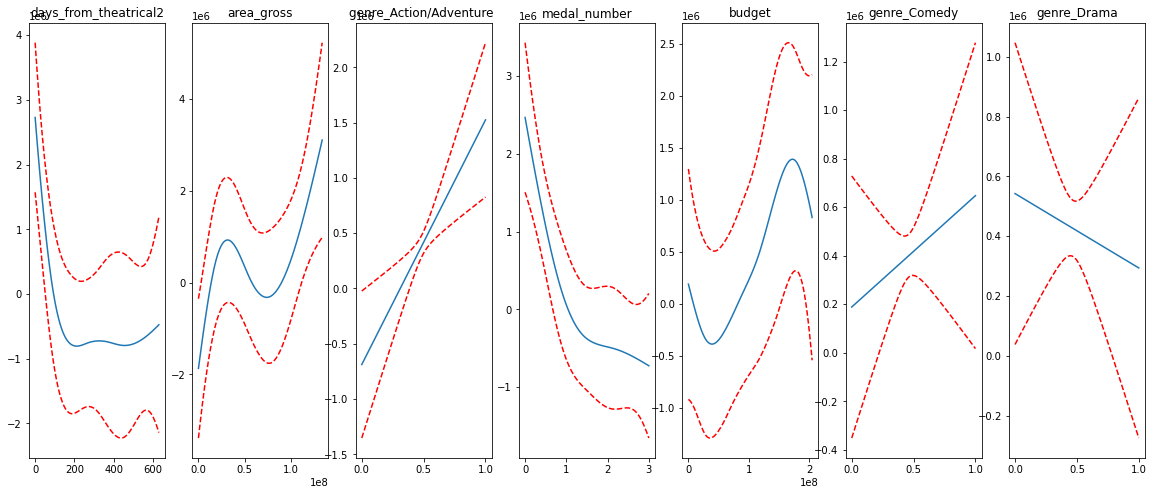

In [50]:
plt.rcParams['figure.figsize'] = (20, 8)
fig, axs = plt.subplots(1, 7)
titles = FEATURE_COLS
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i]);

In [51]:
def cal_error(validation_set):
    error_col = (validation_set['pred']-validation_set[TARGET_COL[0]]).abs()/validation_set[TARGET_COL[0]]
    return error_col.mean()

In [52]:
validation_set['pct_error'] = (validation_set['pred']-validation_set[TARGET_COL[0]]).abs()/validation_set[TARGET_COL[0]]

In [55]:
validation_set[validation_set['pct_error']>2]

,Unnamed: 0,title_id,title,home_territory_observed_medal,pillar_genres,imdb_id,theatrical_release_date,offering_start_date,days_from_theatrical2,pct_actives,days_from_max_launch,cumulative_viewing_subs,cumulative_first_views,area_gross,budget,genre_Action/Adventure,genre_Comedy,genre_Drama,genre_Horror,genre_Kids/Family,genre_Romance,genre_Sci-Fi,genre_Suspense/Thriller,medal_Bronze,medal_Gold,medal_Platinum,medal_Silver,medal_number,log_cumulative_first_views,platform,pred,pct_error
0,42,GYabfWwS74zWCogEAAABO,Profile,Bronze,Suspense/Thriller,tt7826276,2021-05-14,2022-01-01,232,0.01,-359,235653,866,"730,290.00",0.00,0,0,0,0,0,0,0,1,1,0,0,0,3,9.76,1.00,"1,282,702.41",4.44


In [56]:
validation_set.groupby(['home_territory_observed_medal']).pct_error.mean()

home_territory_observed_medal
Bronze     0.67
Gold       0.30
Platinum   0.23
Silver     0.45
Name: pct_error, dtype: float64

In [57]:
validation_set.groupby(['pillar_genres']).pct_error.mean()

pillar_genres
Action/Adventure    0.23
Comedy              0.56
Drama               0.38
Horror              0.38
Kids/Family         0.29
Sci-Fi              0.00
Suspense/Thriller   0.74
Name: pct_error, dtype: float64

### 1.13 Bayesian Regression Scoring

#####1.131 Scoring 1

In [58]:
training_data.head()

,Unnamed: 0,title_id,title,home_territory_observed_medal,pillar_genres,imdb_id,theatrical_release_date,offering_start_date,days_from_theatrical2,pct_actives,days_from_max_launch,cumulative_viewing_subs,cumulative_first_views,area_gross,budget,genre_Action/Adventure,genre_Comedy,genre_Drama,genre_Horror,genre_Kids/Family,genre_Romance,genre_Sci-Fi,genre_Suspense/Thriller,medal_Bronze,medal_Gold,medal_Platinum,medal_Silver,medal_number,log_cumulative_first_views,platform
0,0,GYPXEhQg3DFbCwwEAAADm,News of the World,Silver,Action/Adventure,tt6878306,2020-12-25,2021-09-05,250,0.09,-219,2557041,25362,"2,250,430.00","38,000,000.00",1,0,0,0,0,0,0,0,0,0,0,1,2,14.63,1.00
2,2,GYXB0OgEQO5OhegEAAAAl,King Richard,Platinum,Drama,tt9620288,2021-11-19,2021-11-19,0,0.24,-548,7612114,236213,"5,406,033.00","50,000,000.00",0,0,1,0,0,0,0,0,0,0,1,0,0,17.85,1.00
4,4,GYbzvWABDj8LDwgEAAAAp,The Last Duel,Gold,Drama,tt4244994,2021-10-15,2022-01-14,91,0.16,-513,5012315,33314,"4,759,151.00","100,000,000.00",0,0,1,0,0,0,0,0,0,1,0,0,1,15.02,1.00
5,5,GYm0w5wSRXaTDYQEAAAD4,Last Night in Soho,Silver,Suspense/Thriller,tt9639470,2021-10-29,2022-07-01,245,0.07,-527,2005376,8975,"4,178,460.00","43,000,000.00",0,0,0,0,0,0,0,1,0,0,0,1,2,13.13,1.00
6,6,GYd9P0QTRLMLDJwEAAAAP,Antlers,Silver,Horror,tt7740510,2021-10-11,2022-02-11,123,0.09,-509,2614867,14444,"4,271,346.00",0.00,0,0,0,1,0,0,0,0,0,0,0,1,2,13.82,1.00


In [60]:
X = training_data[FEATURE_COLS]
y = training_data[TARGET_COL]
gam = LinearGAM(n_splines=10).fit(X, y)

In [61]:
# gam.summary()

In [62]:
pred_day = [*range(0, 200, 15)]
df = pd.DataFrame(pred_day, columns =['days_from_theatrical2'])

In [63]:
scoring_data = training_data[META_COLS+FEATURE_COLS].copy()
scoring_data.drop(['days_from_theatrical2'], axis = 1, inplace = True)

In [64]:
def cartesian_product_basic(left, right):
    return (
       left.assign(key=1).merge(right.assign(key=1), on='key').drop('key', 1))

In [65]:
scoring_data=cartesian_product_basic(scoring_data, df)

In [66]:
scoring_data.head()

,title_id,title,home_territory_observed_medal,pillar_genres,imdb_id,area_gross,genre_Action/Adventure,medal_number,budget,genre_Comedy,genre_Drama,days_from_theatrical2
0,GYPXEhQg3DFbCwwEAAADm,News of the World,Silver,Action/Adventure,tt6878306,"2,250,430.00",1,2,"38,000,000.00",0,0,0
1,GYPXEhQg3DFbCwwEAAADm,News of the World,Silver,Action/Adventure,tt6878306,"2,250,430.00",1,2,"38,000,000.00",0,0,15
2,GYPXEhQg3DFbCwwEAAADm,News of the World,Silver,Action/Adventure,tt6878306,"2,250,430.00",1,2,"38,000,000.00",0,0,30
3,GYPXEhQg3DFbCwwEAAADm,News of the World,Silver,Action/Adventure,tt6878306,"2,250,430.00",1,2,"38,000,000.00",0,0,45
4,GYPXEhQg3DFbCwwEAAADm,News of the World,Silver,Action/Adventure,tt6878306,"2,250,430.00",1,2,"38,000,000.00",0,0,60


In [67]:
pred = gam.predict(scoring_data[FEATURE_COLS])
pred = pd.DataFrame(pred)
pred.columns = ['pred']
scoring_data = pd.concat([scoring_data, pred], axis = 1)

In [68]:
scoring_data

,title_id,title,home_territory_observed_medal,pillar_genres,imdb_id,area_gross,genre_Action/Adventure,medal_number,budget,genre_Comedy,genre_Drama,days_from_theatrical2,pred
0,GYPXEhQg3DFbCwwEAAADm,News of the World,Silver,Action/Adventure,tt6878306,"2,250,430.00",1,2,"38,000,000.00",0,0,0,"6,779,711.04"
1,GYPXEhQg3DFbCwwEAAADm,News of the World,Silver,Action/Adventure,tt6878306,"2,250,430.00",1,2,"38,000,000.00",0,0,15,"6,227,603.56"
2,GYPXEhQg3DFbCwwEAAADm,News of the World,Silver,Action/Adventure,tt6878306,"2,250,430.00",1,2,"38,000,000.00",0,0,30,"5,712,937.55"
3,GYPXEhQg3DFbCwwEAAADm,News of the World,Silver,Action/Adventure,tt6878306,"2,250,430.00",1,2,"38,000,000.00",0,0,45,"5,240,963.78"
4,GYPXEhQg3DFbCwwEAAADm,News of the World,Silver,Action/Adventure,tt6878306,"2,250,430.00",1,2,"38,000,000.00",0,0,60,"4,816,932.99"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,GYaqMmQQ6oMNHsAEAAABg,Ron's Gone Wrong,Bronze,Kids/Family,tt7504818,"7,300,225.00",0,3,0.00,0,0,135,"2,287,893.24"
1018,GYaqMmQQ6oMNHsAEAAABg,Ron's Gone Wrong,Bronze,Kids/Family,tt7504818,"7,300,225.00",0,3,0.00,0,0,150,"2,183,737.01"
1019,GYaqMmQQ6oMNHsAEAAABg,Ron's Gone Wrong,Bronze,Kids/Family,tt7504818,"7,300,225.00",0,3,0.00,0,0,165,"2,113,652.55"
1020,GYaqMmQQ6oMNHsAEAAABg,Ron's Gone Wrong,Bronze,Kids/Family,tt7504818,"7,300,225.00",0,3,0.00,0,0,180,"2,070,234.02"


In [69]:
scoring_data['kpi'] = 'viewing_subs'

In [70]:
OUTPUT_COLS = ['title_id', 'imdb_id', 'title', 'home_territory_observed_medal', 'pillar_genres', 'area_gross', 'medal_number', 'budget', 
              'days_from_theatrical2', 'kpi', 'pred']

In [80]:
write_to_sf(scoring_data[OUTPUT_COLS], 'title_level_subs')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning:

Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/



In [81]:
import plotly.express as px

In [1]:
# plot_df = scoring_data
# fig = px.line(plot_df, x="days_from_theatrical2", y="pred", color = 'title',
#               title='Release day V.S. cumulative viewership')
# fig.show()

##### 1.132 Scoring2

In [83]:
scoring_data = training_data[META_COLS+FEATURE_COLS].copy()
scoring_data.drop(['days_from_theatrical2'], axis = 1, inplace = True)

In [84]:
scoring_data = scoring_data.groupby(['home_territory_observed_medal', 'pillar_genres']).mean().reset_index()

In [85]:
pred_day = [*range(0, 200, 15)]
df = pd.DataFrame(pred_day, columns =['days_from_theatrical2'])

In [86]:
scoring_data=cartesian_product_basic(scoring_data, df)

In [87]:
pred = gam.predict(scoring_data[FEATURE_COLS])
pred = pd.DataFrame(pred)
pred.columns = ['pred']
scoring_data = pd.concat([scoring_data, pred], axis = 1)

In [88]:
scoring_data.head()

,home_territory_observed_medal,pillar_genres,area_gross,genre_Action/Adventure,medal_number,budget,genre_Comedy,genre_Drama,days_from_theatrical2,pred
0,Bronze,Comedy,"700,160.00",0,3,0.00,1,0,0,"5,114,935.75"
1,Bronze,Comedy,"700,160.00",0,3,0.00,1,0,15,"4,562,828.26"
2,Bronze,Comedy,"700,160.00",0,3,0.00,1,0,30,"4,048,162.25"
3,Bronze,Comedy,"700,160.00",0,3,0.00,1,0,45,"3,576,188.48"
4,Bronze,Comedy,"700,160.00",0,3,0.00,1,0,60,"3,152,157.70"


In [90]:
scoring_data['title_id'] = np.NAN
scoring_data['imdb_id'] = np.NAN
scoring_data['title'] = np.NAN
scoring_data['kpi'] = 'viewing_subs'

In [91]:
write_to_sf(scoring_data[OUTPUT_COLS], 'genre_level_subs')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning:

Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/



# 2. First Views

In [92]:
# medal_onehot = pd.get_dummies(training_data['home_territory_observed_medal'], prefix='medal')
# training_data=pd.concat([training_data, medal_onehot], axis = 1)

In [93]:
training_data['log_cumulative_first_views'] = np.log2(training_data['cumulative_first_views']+10000)

In [94]:
# training_data['power_cumulative_first_views'] = np.power(training_data['cumulative_first_views'], (1/4))

In [95]:
META_COLS = ['title_id', 'title', 'home_territory_observed_medal', 'pillar_genres', 'imdb_id']

In [96]:
FEATURE_COLS = ['days_from_theatrical2', 'area_gross', 'budget' , 'genre_Action/Adventure ', 'genre_Comedy', 'genre_Drama', 'medal_number']
                #, 'genre_Horror ', 'genre_Kids/Family', 'genre_Romance', 'genre_Sci-Fi', 'genre_Suspense/Thriller', 'medal_Bronze', 'medal_Gold'

In [97]:
TARGET_COL = ['log_cumulative_first_views'] # cumulative_first_views

## 2.1 Cross Validation

In [98]:
def cal_error(validation_set):
    error_col = (validation_set['pred']-validation_set[TARGET_COL[0]]).abs()/validation_set[TARGET_COL[0]].abs()
    return error_col.mean()

### 2.11 Random Forest CV

In [18]:
training_data = training_data[training_data['days_from_max_launch']<= 0]

In [19]:
num_folds = len(training_data['title_id'].unique())
group_kfold = GroupKFold(n_splits=num_folds)

In [139]:
num_folds

72

In [242]:
validation_set = pd.DataFrame()
feature_importances = pd.DataFrame()
model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

for train_index, test_index in group_kfold.split(training_data, groups=training_data['title_id'].values):
    train_df, test_df = training_data.iloc[train_index], training_data.iloc[test_index]
#     print ("Validation Title: " + test_df['title'].values[0])
    try:
        ## fit_predict prelaunch model
        X_train, X_test = train_df[FEATURE_COLS], test_df[FEATURE_COLS]
        y_train, y_test = train_df[TARGET_COL], test_df[TARGET_COL]

        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        pred = pd.DataFrame(pred)
        pred.columns = ['pred']
        test_df.reset_index(inplace = True, drop = True)
        test_df = pd.concat([test_df, pred], axis = 1)
        validation_set = pd.concat([validation_set, test_df], axis = 0)

        fi = model.feature_importances_
        fi_df = pd.DataFrame([fi])
        fi_df.columns = FEATURE_COLS
        fi_df['title_id'] = test_df['title_id'].values[0]
        fi_df['title'] = test_df['title'].values[0]
        feature_importances=pd.concat([feature_importances, fi_df], axis = 0)

    except Exception as e:
        print (e)

KeyboardInterrupt: 

In [141]:
validation_set.to_csv('validation_set.csv')

In [142]:
validation_set['pct_error'] = (validation_set['pred']-validation_set[TARGET_COL[0]]).abs()/validation_set[TARGET_COL[0]]

In [143]:
validation_set[validation_set['pct_error']>2][META_COLS + ['days_from_theatrical2', 'budget', 'area_gross', 'pred'] + TARGET_COL]

,title_id,title,home_territory_observed_medal,pillar_genres,imdb_id,days_from_theatrical2,budget,area_gross,pred,log_cumulative_first_views


In [144]:
cal_error(validation_set) #0.062

0.062237796378732675

In [146]:
def cal_true_error(validation_set):
    error_col = (validation_set['pred_antilog']-validation_set['cumulative_first_views']).abs()/validation_set['cumulative_first_views']
    return error_col.mean()

In [147]:
validation_set['pred_antilog'] = 2**validation_set['pred'] - 1

In [148]:
cal_true_error(validation_set)

0.8188520750552821

In [145]:
feature_importances.mean()

days_from_theatrical2     0.21
area_gross                0.11
budget                    0.07
genre_Action/Adventure    0.15
genre_Comedy              0.10
genre_Drama               0.03
medal_Bronze              0.30
medal_Gold                0.03
dtype: float64

### 2.12 Bayesian Regression CV

In [99]:
# !pip install pygam

In [100]:
from pygam import LinearGAM, s, PoissonGAM

In [101]:
training_data[FEATURE_COLS].isnull().sum()/len(training_data)

days_from_theatrical2     0.00
area_gross                0.00
budget                    0.00
genre_Action/Adventure    0.00
genre_Comedy              0.00
genre_Drama               0.00
medal_number              0.00
dtype: float64

In [102]:
training_data['area_gross'] = training_data['area_gross'].fillna(0)
training_data['budget'] = training_data['budget'].fillna(0)

In [103]:
### DOWNSIDE --- DO NOT TAKE NULL ####
validation_set = pd.DataFrame()
# feature_importances = pd.DataFrame()
# gam = LinearGAM(s(0))

for train_index, test_index in group_kfold.split(training_data, groups=training_data['title_id'].values):
    train_df, test_df = training_data.iloc[train_index], training_data.iloc[test_index]
#     print ("Validation Title: " + test_df['title'].values[0])
    try:
        ## fit_predict prelaunch model|
        X_train, X_test = train_df[FEATURE_COLS], test_df[FEATURE_COLS]
        y_train, y_test = train_df[TARGET_COL], test_df[TARGET_COL]

        gam = LinearGAM(n_splines=10).fit(X_train, y_train)
        pred = gam.predict(X_test)
        pred = pd.DataFrame(pred)
        pred.columns = ['pred']
        test_df.reset_index(inplace = True, drop = True)
        test_df = pd.concat([test_df, pred], axis = 1)
        validation_set = pd.concat([validation_set, test_df], axis = 0)

    except Exception as e:
        print (e)
        raise 

In [104]:
cal_error(validation_set) # 0.040

0.039730085104848406

In [105]:
def cal_true_error(validation_set):
    error_col = (validation_set['pred_antilog']-validation_set['cumulative_first_views']).abs()/validation_set['cumulative_first_views']
    return error_col.mean()

In [106]:
validation_set['pred_antilog'] = 2**(validation_set['pred']) - 10000

In [107]:
cal_true_error(validation_set)

0.8165372410972868

In [108]:
validation_set['pct_error'] = (validation_set['pred_antilog']-validation_set['cumulative_first_views']).abs()/validation_set['cumulative_first_views']

In [109]:
validation_set[validation_set['pct_error']>2][META_COLS + ['days_from_theatrical2', 'budget', 'area_gross', 'pred'] + TARGET_COL]

,title_id,title,home_territory_observed_medal,pillar_genres,imdb_id,days_from_theatrical2,budget,area_gross,pred,log_cumulative_first_views
0,GYQBEaQwta8PCAAEAAAA-,Reminiscence,Platinum,Suspense/Thriller,tt3272066,0,"54,000,000.00","1,950,793.00",17.83,16.36
0,GY2Vw6gENDp_DwgEAAAFS,Amsterdam,Gold,Comedy,tt10304142,32,"80,000,000.00","6,444,896.00",16.14,14.60
0,GYFTsgguYHcPDwgEAAAAK,The Personal History of David Copperfield,Bronze,Drama,tt6439020,246,"15,600,000.00","475,800.00",14.02,13.51
0,GYij31wBohZA3MQEAAAKa,Fantastic Beasts: The Secrets of Dumbledore,Platinum,Action/Adventure,tt4123432,45,"200,000,000.00","42,151,256.00",19.14,17.30
0,GYnEqqwAqmj3DwwEAAAAD,The Card Counter,Silver,Action/Adventure,tt11196036,257,0.00,"1,039,580.00",15.33,14.20
0,GYpd0sACo9rqfUAEAAABf,The Bob's Burgers Movie,Gold,Comedy,tt7466442,46,"38,000,000.00","12,416,819.00",16.38,14.80
0,GYx9RagJNMcPDbgEAAADZ,See How They Run,Silver,Comedy,tt13640696,46,"40,000,000.00","3,007,657.00",15.77,14.18
0,GYabfWwS74zWCogEAAABO,Profile,Bronze,Suspense/Thriller,tt7826276,232,0.00,"730,290.00",13.83,13.41


In [110]:
X = training_data[FEATURE_COLS]
y = training_data[TARGET_COL]
gam = LinearGAM(n_splines=10).fit(X, y)

In [111]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     17.0327
Link Function:                     IdentityLink Log Likelihood:                                   -75.8207
Number of Samples:                           73 AIC:                                              187.7068
                                                AICc:                                             200.4261
                                                GCV:                                                0.9908
                                                Scale:                                               0.586
                                                Pseudo R-Squared:                                   0.8824
Feature Function                  Lam

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning:

KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 




In [112]:
import matplotlib.pyplot as plt

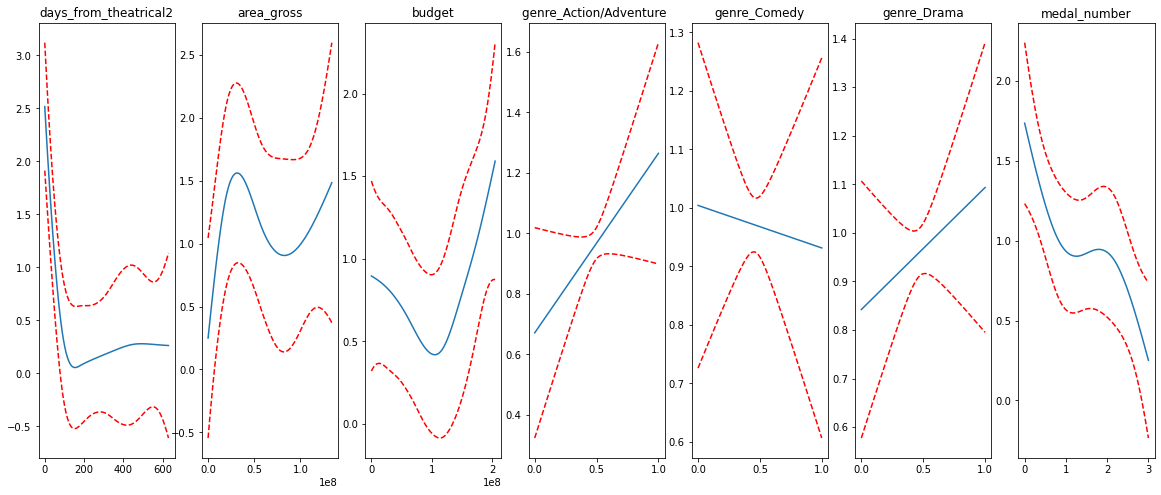

In [113]:
plt.rcParams['figure.figsize'] = (20, 8)
fig, axs = plt.subplots(1, 7)
titles = FEATURE_COLS
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i]);

In [114]:
validation_set.groupby(['home_territory_observed_medal']).pct_error.mean()

home_territory_observed_medal
Bronze     1.17
Gold       0.70
Platinum   0.67
Silver     0.80
Name: pct_error, dtype: float64

In [115]:
validation_set.groupby(['pillar_genres']).pct_error.mean()

pillar_genres
Action/Adventure    0.68
Comedy              1.32
Drama               0.86
Horror              0.21
Kids/Family         0.46
Sci-Fi              0.56
Suspense/Thriller   1.02
Name: pct_error, dtype: float64

In [116]:
validation_set.head()

,Unnamed: 0,title_id,title,home_territory_observed_medal,pillar_genres,imdb_id,theatrical_release_date,offering_start_date,days_from_theatrical2,pct_actives,days_from_max_launch,cumulative_viewing_subs,cumulative_first_views,area_gross,budget,genre_Action/Adventure,genre_Comedy,genre_Drama,genre_Horror,genre_Kids/Family,genre_Romance,genre_Sci-Fi,genre_Suspense/Thriller,medal_Bronze,medal_Gold,medal_Platinum,medal_Silver,medal_number,log_cumulative_first_views,platform,pred,pred_antilog,pct_error
0,33,GYzrqHgFIqsM2ewEAAAD4,Don't Worry Darling,Gold,Suspense/Thriller,tt10731256,2022-09-23,2022-11-07,45,0.21,-856,6373492,77468,"19,353,213.00","20,000,000.00",0,0,0,0,0,0,0,1,0,1,0,0,1,16.42,1.00,16.59,"88,837.85",0.15
0,17,GYSbJuAuzchDCwgEAAAAC,Cry Macho,Gold,Drama,tt1924245,2021-09-17,2021-09-17,0,0.17,-485,4826766,140629,"4,426,161.00",0.00,0,0,1,0,0,0,0,0,0,1,0,0,1,17.20,1.00,17.42,"165,459.23",0.18
0,56,GYIHBbgg_NZ2TjQEAAADx,Kajillionaire,Bronze,Drama,tt8143990,2020-09-25,2021-06-01,249,0.02,-128,589660,2482,"215,675.00",0.00,0,0,1,0,0,0,0,0,1,0,0,0,3,13.61,1.00,14.03,"6,713.21",1.70
0,19,GYK0x7gXCza4OwwEAAADl,In The Heights,Platinum,Drama,tt1321510,2021-06-10,2021-06-10,0,0.21,-386,5657876,203752,"11,504,710.00","55,000,000.00",0,0,1,0,0,0,0,0,0,0,1,0,0,17.71,1.00,18.50,"361,571.79",0.77
0,52,GYKabGAV4LqS1oAEAAABb,Let Him Go,Silver,Drama,tt9340860,2020-11-06,2021-07-04,237,0.10,-170,2608832,26191,"4,000,470.00",0.00,0,0,1,0,0,0,0,0,0,0,0,1,2,15.14,1.00,14.87,"19,898.57",0.24


### 2.13 GAM Scoring

##### 2.131 Scoring 1

In [117]:
training_data.head()

,Unnamed: 0,title_id,title,home_territory_observed_medal,pillar_genres,imdb_id,theatrical_release_date,offering_start_date,days_from_theatrical2,pct_actives,days_from_max_launch,cumulative_viewing_subs,cumulative_first_views,area_gross,budget,genre_Action/Adventure,genre_Comedy,genre_Drama,genre_Horror,genre_Kids/Family,genre_Romance,genre_Sci-Fi,genre_Suspense/Thriller,medal_Bronze,medal_Gold,medal_Platinum,medal_Silver,medal_number,log_cumulative_first_views,platform
0,0,GYPXEhQg3DFbCwwEAAADm,News of the World,Silver,Action/Adventure,tt6878306,2020-12-25,2021-09-05,250,0.09,-219,2557041,25362,"2,250,430.00","38,000,000.00",1,0,0,0,0,0,0,0,0,0,0,1,2,15.11,1.00
2,2,GYXB0OgEQO5OhegEAAAAl,King Richard,Platinum,Drama,tt9620288,2021-11-19,2021-11-19,0,0.24,-548,7612114,236213,"5,406,033.00","50,000,000.00",0,0,1,0,0,0,0,0,0,0,1,0,0,17.91,1.00
4,4,GYbzvWABDj8LDwgEAAAAp,The Last Duel,Gold,Drama,tt4244994,2021-10-15,2022-01-14,91,0.16,-513,5012315,33314,"4,759,151.00","100,000,000.00",0,0,1,0,0,0,0,0,0,1,0,0,1,15.40,1.00
5,5,GYm0w5wSRXaTDYQEAAAD4,Last Night in Soho,Silver,Suspense/Thriller,tt9639470,2021-10-29,2022-07-01,245,0.07,-527,2005376,8975,"4,178,460.00","43,000,000.00",0,0,0,0,0,0,0,1,0,0,0,1,2,14.21,1.00
6,6,GYd9P0QTRLMLDJwEAAAAP,Antlers,Silver,Horror,tt7740510,2021-10-11,2022-02-11,123,0.09,-509,2614867,14444,"4,271,346.00",0.00,0,0,0,1,0,0,0,0,0,0,0,1,2,14.58,1.00


In [118]:
X = training_data[FEATURE_COLS]
y = training_data[TARGET_COL]
gam = LinearGAM(n_splines=10).fit(X, y)

In [119]:
pred_day = [*range(0, 200, 15)]
df = pd.DataFrame(pred_day, columns =['days_from_theatrical2'])

In [120]:
scoring_data = training_data[META_COLS+FEATURE_COLS].copy()
scoring_data.drop(['days_from_theatrical2'], axis = 1, inplace = True)

In [121]:
def cartesian_product_basic(left, right):
    return (
       left.assign(key=1).merge(right.assign(key=1), on='key').drop('key', 1))

In [122]:
scoring_data=cartesian_product_basic(scoring_data, df)

In [123]:
pred = gam.predict(scoring_data[FEATURE_COLS])
pred = pd.DataFrame(pred)
pred.columns = ['pred']
scoring_data = pd.concat([scoring_data, pred], axis = 1)

In [124]:
scoring_data.head()

,title_id,title,home_territory_observed_medal,pillar_genres,imdb_id,area_gross,budget,genre_Action/Adventure,genre_Comedy,genre_Drama,medal_number,days_from_theatrical2,pred
0,GYPXEhQg3DFbCwwEAAADm,News of the World,Silver,Action/Adventure,tt6878306,"2,250,430.00","38,000,000.00",1,0,0,2,0,17.41
1,GYPXEhQg3DFbCwwEAAADm,News of the World,Silver,Action/Adventure,tt6878306,"2,250,430.00","38,000,000.00",1,0,0,2,15,16.94
2,GYPXEhQg3DFbCwwEAAADm,News of the World,Silver,Action/Adventure,tt6878306,"2,250,430.00","38,000,000.00",1,0,0,2,30,16.50
3,GYPXEhQg3DFbCwwEAAADm,News of the World,Silver,Action/Adventure,tt6878306,"2,250,430.00","38,000,000.00",1,0,0,2,45,16.11
4,GYPXEhQg3DFbCwwEAAADm,News of the World,Silver,Action/Adventure,tt6878306,"2,250,430.00","38,000,000.00",1,0,0,2,60,15.77


In [125]:
scoring_data['pred'] = 2**(scoring_data['pred']) - 10000

In [126]:
scoring_data['kpi'] = 'first_views'

In [132]:
scoring_data_45 = scoring_data[scoring_data['days_from_theatrical2'] == 45][['title_id', 'pred']].rename(columns = {'pred':'base'}).copy()
scoring_data = scoring_data.merge(scoring_data_45, on = ['title_id'])
scoring_data['multipler'] = scoring_data['pred']/scoring_data['base']

In [128]:
write_to_sf(scoring_data[OUTPUT_COLS], 'title_level_first_views')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning:

Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/



In [129]:
import plotly.express as px

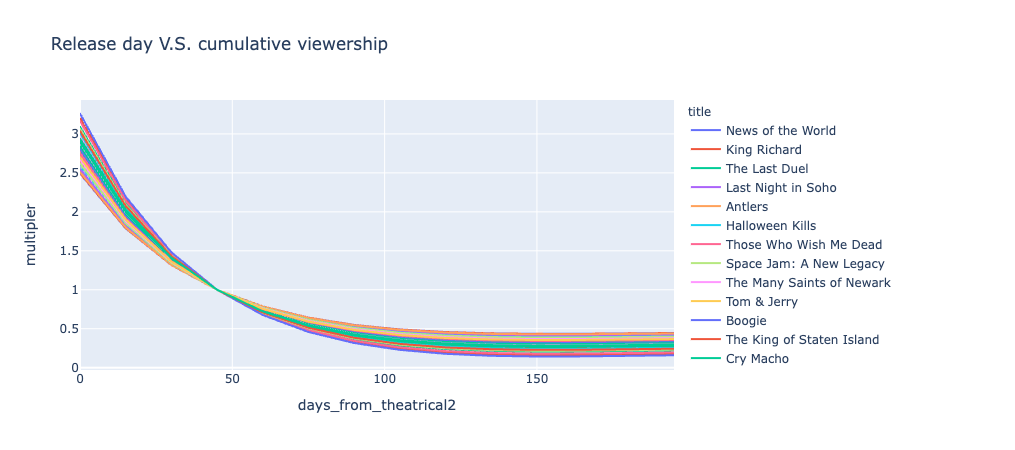

In [133]:
plot_df = scoring_data
fig = px.line(plot_df, x="days_from_theatrical2", y="multipler", color = 'title',
              title='Release day V.S. cumulative viewership')
fig.show()

##### 1.132 Scoring2

In [134]:
scoring_data = training_data[META_COLS+FEATURE_COLS].copy()
scoring_data.drop(['days_from_theatrical2'], axis = 1, inplace = True)

In [135]:
scoring_data.head()

,title_id,title,home_territory_observed_medal,pillar_genres,imdb_id,area_gross,budget,genre_Action/Adventure,genre_Comedy,genre_Drama,medal_number
0,GYPXEhQg3DFbCwwEAAADm,News of the World,Silver,Action/Adventure,tt6878306,"2,250,430.00","38,000,000.00",1,0,0,2
2,GYXB0OgEQO5OhegEAAAAl,King Richard,Platinum,Drama,tt9620288,"5,406,033.00","50,000,000.00",0,0,1,0
4,GYbzvWABDj8LDwgEAAAAp,The Last Duel,Gold,Drama,tt4244994,"4,759,151.00","100,000,000.00",0,0,1,1
5,GYm0w5wSRXaTDYQEAAAD4,Last Night in Soho,Silver,Suspense/Thriller,tt9639470,"4,178,460.00","43,000,000.00",0,0,0,2
6,GYd9P0QTRLMLDJwEAAAAP,Antlers,Silver,Horror,tt7740510,"4,271,346.00",0.00,0,0,0,2


In [136]:
scoring_data = scoring_data.groupby(['home_territory_observed_medal', 'pillar_genres']).mean().reset_index()

In [137]:
pred_day = [*range(0, 200, 15)]
df = pd.DataFrame(pred_day, columns =['days_from_theatrical2'])

In [138]:
scoring_data=cartesian_product_basic(scoring_data, df)

In [139]:
pred = gam.predict(scoring_data[FEATURE_COLS])
pred = pd.DataFrame(pred)
pred.columns = ['pred']
scoring_data = pd.concat([scoring_data, pred], axis = 1)

In [140]:
scoring_data.head()

,home_territory_observed_medal,pillar_genres,area_gross,budget,genre_Action/Adventure,genre_Comedy,genre_Drama,medal_number,days_from_theatrical2,pred
0,Bronze,Comedy,"700,160.00",0.00,0,1,0,3,0,16.08
1,Bronze,Comedy,"700,160.00",0.00,0,1,0,3,15,15.61
2,Bronze,Comedy,"700,160.00",0.00,0,1,0,3,30,15.17
3,Bronze,Comedy,"700,160.00",0.00,0,1,0,3,45,14.78
4,Bronze,Comedy,"700,160.00",0.00,0,1,0,3,60,14.45


In [141]:
scoring_data['title_id'] = np.NAN
scoring_data['imdb_id'] = np.NAN
scoring_data['title'] = np.NAN
scoring_data['kpi'] = 'first_views'

In [142]:
scoring_data['pred'] = 2**scoring_data['pred'] - 10000

In [143]:
write_to_sf(scoring_data[OUTPUT_COLS], 'genre_level_first_views')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning:

Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/



# WRITE TO SF

In [5]:
import boto3
import io

In [6]:
def to_s3(filename, output_bucket, content):
    client = boto3.client('s3')
    client.put_object(Bucket=output_bucket, Key=filename, Body=content)

In [7]:
output_bucket = 'hbo-outbound-datascience-content-dev'
s3 = boto3.resource('s3')
bucket = s3.Bucket(output_bucket)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [8]:
def write_to_sf(df, file_name):
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index = False)
    content = csv_buffer.getvalue()
    filename = 'movie_windowing/movie_window_prediction_{}.csv'.format(file_name)
    to_s3(filename, output_bucket, content)

In [9]:
OUTPUT_COLS = ['title_id', 'imdb_id', 'title', 'home_territory_observed_medal', 'pillar_genres', 'area_gross', 'medal_number', 'budget', 'days_from_theatrical2', 'kpi', 'pred']

In [10]:
from abc import ABCMeta, abstractmethod

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError
    

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_DEV","WORKSPACE")

def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

In [154]:
run_query('''
create or replace table max_dev.workspace.movie_window_prediction_title_level_subs
(
title_id	VARCHAR,
imdb_id	VARCHAR,
title	VARCHAR,
home_territory_observed_medal	VARCHAR,
pillar_genres	VARCHAR,
area_gross	FLOAT,
medal_number	INT,
budget	FLOAT,
days_from_theatrical2	INT,
kpi	VARCHAR,
pred FLOAT
);

''')


,status
0,Table MOVIE_WINDOW_PREDICTION_TITLE_LEVEL_SUBS...


In [18]:
# run_query('''
# create or replace table max_dev.workspace.movie_window_prediction_actual_value
# (
# title_id	VARCHAR,
# days_from_theatrical2 int,
# value FLOAT,
# kpi	VARCHAR
# );

# ''')

,status
0,Table MOVIE_WINDOW_PREDICTION_ACTUAL_VALUE suc...


In [ ]:
#first_views #genre_level_first_views

In [155]:
run_query('''
copy into max_dev.workspace.movie_window_prediction_title_level_subs
    from(
        select
              $1, $2, $3, $4, $5, $6, $7, $8, $9, $10, $11
        from @HBO_OUTBOUND_DATASCIENCE_CONTENT_DEV/movie_windowing/movie_window_prediction_title_level_subs.csv
        )
    file_format = (type = csv null_if=('') skip_header = 1  FIELD_OPTIONALLY_ENCLOSED_BY='"')
    on_error = 'CONTINUE';

''')

,file,status,rows_parsed,rows_loaded,error_limit,errors_seen,first_error,first_error_line,first_error_character,first_error_column_name
0,s3://hbo-outbound-datascience-content-dev/movi...,LOADED,1022,1022,1022,0,None,None,None,None


In [19]:
# run_query('''
# copy into max_dev.workspace.movie_window_prediction_actual_value
#     from(
#         select
#               $1, $2, $3, $4
#         from @HBO_OUTBOUND_DATASCIENCE_CONTENT_DEV/movie_windowing/movie_window_prediction_actual_value.csv
#         )
#     file_format = (type = csv null_if=('') skip_header = 1  FIELD_OPTIONALLY_ENCLOSED_BY='"')
#     on_error = 'CONTINUE';

# ''')

,file,status,rows_parsed,rows_loaded,error_limit,errors_seen,first_error,first_error_line,first_error_character,first_error_column_name
0,s3://hbo-outbound-datascience-content-dev/movi...,LOADED,206,206,206,0,None,None,None,None


In [189]:
training_data.head()

,Unnamed: 0,title_id,title,home_territory_observed_medal,pillar_genres,imdb_id,theatrical_release_date,offering_start_date,days_from_theatrical2,pct_actives,days_from_max_launch,cumulative_viewing_subs,cumulative_first_views,area_gross,budget,genre_Action/Adventure,genre_Comedy,genre_Drama,genre_Horror,genre_Kids/Family,genre_Romance,genre_Sci-Fi,genre_Suspense/Thriller,medal_number,platform,medal_Bronze,medal_Gold,medal_Platinum,medal_Silver,log_cumulative_first_views
0,0,GYPXEhQg3DFbCwwEAAADm,News of the World,Silver,Action/Adventure,tt6878306,2020-12-25,2021-09-05,250,0.09,-219,2557041,25362,"2,250,430.00","38,000,000.00",1,0,0,0,0,0,0,0,2,1.00,0,0,0,1,14.63
3,3,GYbzvWABDj8LDwgEAAAAp,The Last Duel,Gold,Drama,tt4244994,2021-10-15,2022-01-14,91,0.16,-513,5012315,33314,"4,759,151.00","100,000,000.00",0,0,1,0,0,0,0,0,1,1.00,0,1,0,0,15.02
4,4,GYm0w5wSRXaTDYQEAAAD4,Last Night in Soho,Silver,Suspense/Thriller,tt9639470,2021-10-29,2022-07-01,245,0.07,-527,2005376,8975,"4,178,460.00","43,000,000.00",0,0,0,0,0,0,0,1,2,1.00,0,0,0,1,13.13
6,6,GYd9P0QTRLMLDJwEAAAAP,Antlers,Silver,Horror,tt7740510,2021-10-11,2022-02-11,123,0.09,-509,2614867,14444,"4,271,346.00",0.00,0,0,0,1,0,0,0,0,2,1.00,0,0,0,1,13.82
7,7,GYfinBwyKBImYsgEAAACn,Halloween Kills,Silver,Horror,tt10665338,2021-10-15,2022-03-18,137,0.10,-513,2838005,28030,"49,404,980.00","20,000,000.00",0,0,0,1,0,0,0,0,2,1.00,0,0,0,1,14.77


In [15]:
df1 = training_data[['title_id', 'days_from_theatrical2', 'cumulative_viewing_subs']].rename(columns = {'cumulative_viewing_subs':'value'})
df1['kpi'] = 'viewing_subs'
df2 = training_data[['title_id', 'days_from_theatrical2', 'cumulative_first_views']].rename(columns = {'cumulative_first_views':'value'})
df2['kpi'] = 'first_views'
actual_data = pd.concat([df1, df2], axis = 0)

In [16]:
write_to_sf(actual_data, 'actual_value')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [1]:
actual_data.tail()

NameError: name 'actual_data' is not defined